# Custom Iterator Tutorial
This tutorial provides a brief guideline of using MXNet to build custom iterators to load your own custom data structures into MXNet computational graph, especially when data does not fit into memory.

## Recap on data iterator
Let's step back on different methods that you can generate MXNet data iterators. 
- Feeding: When the data fits in memory, one way you could try is to directly represent the training samples and labels in NDArray and use the API mxnet.io.NDArrayIter or other [data loading API](http://mxnet.io/api/python/io.html) to generate the iterators. 
- Reading from file: When the data is saved in some specific format, you could use the corresponding iterator generator like [CSVIter](http://mxnet.io/api/python/io.html#mxnet.io.CSVIter). 
A more complete list of MXNet default data iterators is [here](http://mxnet.io/api/python/io.html#data-iterators).

However, for other special data structures, you need to write some extra code to build your own custom data iterator. Before digging into this tutorial, you may want to check the [LSTM](http://mxnet.io/tutorials/python/char_lstm.html), [Matrix Factorization](http://mxnet.io/tutorials/python/matrix_factorization.html), and [Bucketing](http://mxnet.io/how_to/bucketing.html) if your purpose is similar with those tutorials.


## Load the data

The data we are going to use is the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) in CSV format, the data can be found in this [web](http://pjreddie.com/projects/mnist-in-csv/).

To download the data:

In [2]:
import os
import urllib
if not os.path.exists('mnist_train.csv'):
    urllib.urlretrieve('http://pjreddie.com/media/files/mnist_train.csv','mnist_train.csv')
if not os.path.exists('mnist_test.csv'):
    urllib.urlretrieve('http://pjreddie.com/media/files/mnist_test.csv', 'mnist_test.csv')


You'll get two files, `mnist_train.csv` that contains 60,000 examples of hand written numbers and mxnist_test.csv that contains 10,000 examples. The first element of each line in the CSV is the label, which is a number between 0 and 9. The rest of the line are 784 numbers between 0 and 255, corresponding to the levels of grey of a matrix of 28x28. Therefore, each line contains an image of 28x28 pixels of a hand written number and its true label.

## Custom Data Iterator

Next we are going to create a custom data Iterator with [mx.io.DataIter](http://mxnet.io/api/python/io.html#mxnet.io.DataIter) as a base class.

We first define the a batch which contains n samples. It also provides name and shape information to MXNet about the data and label.
```
class Batch(object):
    def __init__(self, data_names, data, label_names, label):
        self.data = data
        self.label = label
        self.data_names = data_names
        self.label_names = label_names

    @property
    def provide_data(self):
        return [(n, x.shape) for n, x in zip(self.data_names, self.data)]

    @property
    def provide_label(self):
        return [(n, x.shape) for n, x in zip(self.label_names, self.label)]
```
Then we define a data iterator, which returns a batch of samples and labels each time.
With the new custom iterator inherited from [DataIter](http://mxnet.io/api/python/io.html#mxnet.io.DataIter), we will need to define its functions `reset()`, `next()`, `iter_next()`, `getdata()`, `getlabel()`, `getindex()`, and `getpad()` (Some of them doesn't need to be overloaded).

In `__init__` it could take data in memory or data in the disk to generate the data. Two essential attribute `provide_data` and `provide_label` declare the shape of each batch of data/label. With `next()` function for python 2 and `__next__` for python 3, it enables MXNet to iterate over the data while training. 

In [470]:
import mxnet as mx
import random

class Batch(object):
    def __init__(self, data_names, data, label_names, label):
        self.data = data
        self.label = label
        self.data_names = data_names
        self.label_names = label_names

    @property
    def provide_data(self):
        return [(n, x.shape) for n, x in zip(self.data_names, self.data)]

    @property
    def provide_label(self):
        return [(n, x.shape) for n, x in zip(self.label_names, self.label)]

class DataIter(mx.io.DataIter):# inherits the default DataIter
    def __init__(self, fname, batch_size,num_label,feature_size):
        super(DataIter, self).__init__()
        self.batch_size = batch_size
        self.data = []
        self.label = []
        self.num_label=num_label
        self.cur_batch=0
        self.feature_size=feature_size
        j=0
        for line in file(fname):
            values = line.strip().split(',')
            self.data.append([float(i)/255 for i in values[1:]])
            #l=[1 if int(values[0])==i else 0 for i in range(num_label)]  # one_hot
            l=int(values[0])
            self.label.append(l)
        self.provide_data = [('data', (batch_size, feature_size))]
        self.provide_label = [('softmax_label', (self.batch_size, ))]
                                      
    def __next__(self):
        return self.next()
    
    def next(self):
        if self.cur_batch <= len(self.data) / self.batch_size:
            #print self.cur_batch
            data0 = []
            label0 = []
            for i in range(self.batch_size):
                j = self.cur_batch * self.batch_size + i
                if j>=len(self.data):
                    j-=len(self.data)
                data0.append(self.data[j])
                label0.append(self.label[j])
            data_all = [mx.nd.array(data0)]
            label_all = [mx.nd.array(label0)]
            data_names = ['data']
            self.cur_batch+=1
            label_names = ['softmax_label']
            return Batch(data_names, data_all, label_names, label_all)          
        else:
            raise StopIteration
            
    def iter_next(self):
        return self.cur_batch<=len(self.data)
    
    def getdata(self):
        return next(self).data
    
    def getindex(self):
        return self.cur_batch
    
    def getlabel(self):
        return next(self).label

    def getpad(self):
        return 0
    
    def reset(self):
        self.cur_batch = 0        
feature_size=784  
batch_size=100
train_iter=DataIter('mnist_train.csv',batch_size,num_label,feature_size)
test_iter=DataIter('mnist_test.csv',batch_size,num_label,feature_size)

We define the network as below:

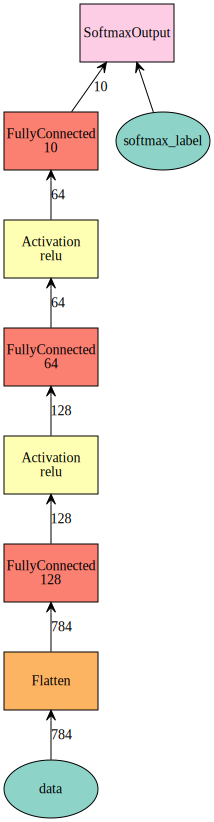

In [471]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)
# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, feature_size)}
mx.viz.plot_network(symbol=mlp, shape=shape)

## Training with the Custom Iterator

Finally, we can directly add the custom iterator as the training data source.

In [472]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
import mxnet.metric
logging.getLogger().setLevel(logging.DEBUG)        
                
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
metric=MultiAccuracy()
model.fit(
    X=train_iter,       # training data
    eval_data=test_iter, # validation data
    #eval_metric=metric,
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [200]	Speed: 10813.33 samples/sec	Train-accuracy=0.112450
INFO:root:Epoch[0] Batch [400]	Speed: 9231.65 samples/sec	Train-accuracy=0.114100
INFO:root:Epoch[0] Batch [600]	Speed: 9270.15 samples/sec	Train-accuracy=0.166000
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=6.206
INFO:root:Epoch[0] Validation-accuracy=0.309604
INFO:root:Epoch[1] Batch [200]	Speed: 14783.20 samples/sec	Train-accuracy=0.488550
INFO:root:Epoch[1] Batch [400]	Speed: 20714.93 samples/sec	Train-accuracy=0.759800
INFO:root:Epoch[1] Batch [600]	Speed: 17817.82 samples/sec	Train-accuracy=0.835600
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=3.462
INFO:root:Epoch[1] Validation-accuracy=0.848812
INFO:root:Epoch[2] Batch [200]	Speed: 24469.15 samples/sec	Train-accuracy=0.868100
INFO:root:Epoch[2] Batch [400]	Speed: 22264.63 samples/sec	Train-accuracy=0.889000
INFO:root:Epoch[2] Batch [600]	Speed: 20682.52 samples/sec	Train-accuracy=0.913150
INF